In [58]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [59]:
import os
print(os.listdir())

['.config', 'shap_global_importance_bar.jpg', 'SHAP_Dependence_Ra.jpg', 'xgboost_feature_importance_gain.jpg', 'shap_beeswarm.jpg', 'SHAP_Dependence_Tsat.jpg', 'Residual_Histogram_and_QQ.jpg', 'Residuals_by_Feature_grid.jpg', 'SHAP_Dependence_kf.jpg', 'max_depth_sensitivity_xgb.jpg', 'learning_rate_sensitivity_xgb.jpg', 'drive', 'Residual_vs_Predicted_CHF.jpg', 'xgb_pred_vs_actual_plain.jpg', 'sample_data']


In [60]:
save_dir = "/content/drive/MyDrive/xgboost_new_figure"
os.makedirs(save_dir, exist_ok=True)  # creates the folder if it doesn't exist
print(f"Figures will be saved to: {save_dir}")

Figures will be saved to: /content/drive/MyDrive/xgboost_new_figure


In [61]:
# Simple & strong XGBoost RandomizedSearchCV (mirrors your LGBM flow) ---

import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
from xgboost import plot_importance


In [62]:
import pandas as pd

DATA_PATH = "/content/drive/MyDrive/chf_database.csv"
df = pd.read_csv(DATA_PATH)

# XGBoost (CV + Early-Stopped Refit via xgb.train)

# 1) Data
feature_columns = ["ks", "P", "Tsat", "Ra", "kf"]
X = df[feature_columns].copy()
y = df['CHF'].astype(float).copy()

# Split (holdout test, then val from train)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.15, random_state=42
)


In [63]:
# -----------------------------
# A) XGBoost CV tuning + test eval (clean)
# -----------------------------
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Base model (simple)  ✅ do NOT name this "xgb"
xgb_model = XGBRegressor(
    objective="reg:squarederror",
    tree_method="hist",
    random_state=42,
    n_jobs=-1,
    verbosity=0
)

# Pipeline (no leakage)
pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("model", xgb_model),
])

# Search space
param_distributions = {
    "model__learning_rate":    [0.04, 0.08, 0.10, 0.12, 0.14, 0.17, 0.20],
    "model__n_estimators":     [300, 450, 600, 650, 700, 800, 1000, 1200, 1400, 1600, 2000],
    "model__max_depth":        [1, 3, 5, 7, 9, 11, 13, 15, 17, 19],
    "model__min_child_weight": [1, 3, 5, 7, 9, 11, 13, 15, 17, 19],
    "model__colsample_bytree": [0.8, 0.9, 1.0],
    "model__subsample":        [0.8, 0.9, 1.0],
    "model__reg_alpha":        [0.0, 0.2, 0.5, 0.6, 1.0],
    "model__reg_lambda":       [0.0, 0.1, 0.5, 0.6, 1.0],
}

cv = KFold(n_splits=5, shuffle=True, random_state=42)

gs = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_distributions,
    n_iter=60,
    scoring="neg_root_mean_squared_error",
    cv=cv,
    n_jobs=-1,
    random_state=42,
    verbose=1,
    refit=True
)

# Fit on TRAIN only
gs.fit(X_train, y_train)

best_idx = gs.best_index_
cv_rmse_mean = -gs.cv_results_["mean_test_score"][best_idx]
cv_rmse_std  =  gs.cv_results_["std_test_score"][best_idx]
print(f"CV RMSE: {cv_rmse_mean:.3f} ± {cv_rmse_std:.3f}")

best_pipe = gs.best_estimator_

# Test prediction
y_pred = best_pipe.predict(X_test)

rmse = float(np.sqrt(mean_squared_error(y_test, y_pred)))
mae  = float(mean_absolute_error(y_test, y_pred))
r2   = float(r2_score(y_test, y_pred))

print("Best params:", gs.best_params_)
print(f"Hold-out RMSE: {rmse:.3f} | R²: {r2:.4f} | MAE: {mae:.3f}")


Fitting 5 folds for each of 60 candidates, totalling 300 fits
CV RMSE: 265.007 ± 53.921
Best params: {'model__subsample': 0.9, 'model__reg_lambda': 0.0, 'model__reg_alpha': 0.0, 'model__n_estimators': 600, 'model__min_child_weight': 9, 'model__max_depth': 11, 'model__learning_rate': 0.1, 'model__colsample_bytree': 0.9}
Hold-out RMSE: 138.701 | R²: 0.9665 | MAE: 109.785


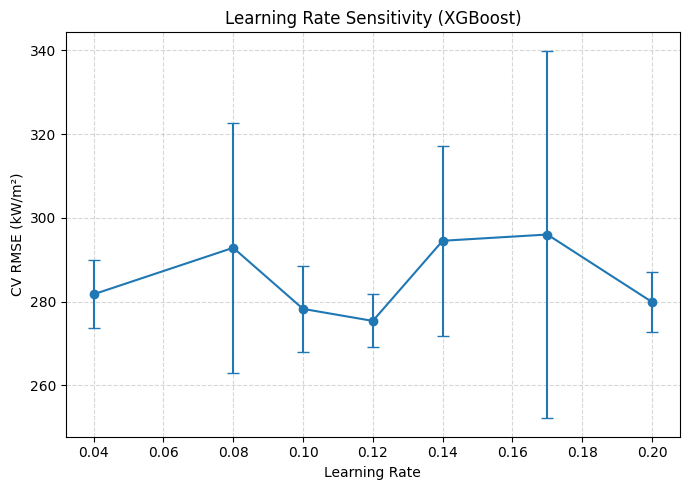

Saved: learning_rate_sensitivity_xgb.jpg


In [64]:
# ============================================================
# >>> INSERT HYPERPARAMETER SENSITIVITY CODE RIGHT HERE <<<
# ============================================================

# (1) Extract CV results
cvres = gs.cv_results_
results_df = pd.DataFrame({
    "mean_test_score": cvres["mean_test_score"],
    "std_test_score":  cvres["std_test_score"],
    "learning_rate":   cvres["param_model__learning_rate"].data,
    "max_depth":       cvres["param_model__max_depth"].data,
})

# Convert neg RMSE → RMSE
results_df["mean_RMSE"] = -results_df["mean_test_score"]
results_df["std_RMSE"]  =  results_df["std_test_score"]

# (2) Aggregate by learning rate
lr_group = results_df.groupby("learning_rate", as_index=False).agg(
    mean_RMSE=("mean_RMSE", "mean"),
    std_RMSE=("mean_RMSE", "std"),
)

# (3) Aggregate by max depth
depth_group = results_df.groupby("max_depth", as_index=False).agg(
    mean_RMSE=("mean_RMSE", "mean"),
    std_RMSE=("mean_RMSE", "std"),
)

# (4) Plot LR sensitivity
plt.figure(figsize=(7,5))
plt.errorbar(
    lr_group["learning_rate"], lr_group["mean_RMSE"],
    yerr=lr_group["std_RMSE"], fmt='-o', capsize=4
)
plt.xlabel("Learning Rate")
plt.ylabel("CV RMSE (kW/m²)")
plt.title("Learning Rate Sensitivity (XGBoost)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()

# ---- Save as high-quality JPEG (300 DPI) ----
plt.savefig("learning_rate_sensitivity_xgb.jpg", format="jpg", dpi=300, bbox_inches='tight')
plt.savefig(f"{save_dir}/learning_rate_sensitivity_xgb.jpg", format="jpg", dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

print("Saved: learning_rate_sensitivity_xgb.jpg")


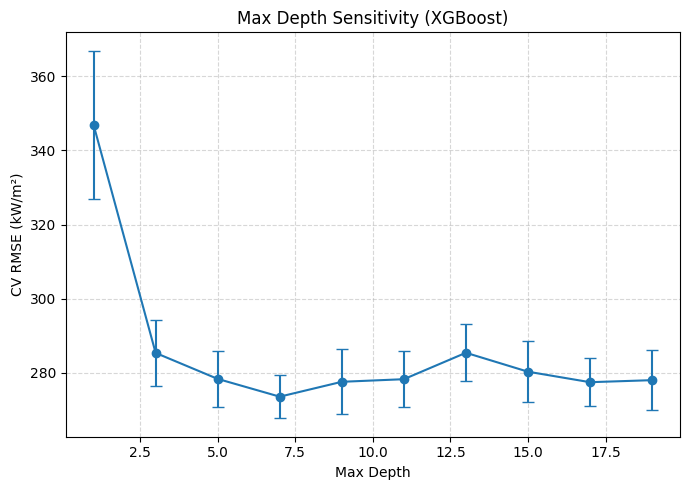

Saved: max_depth_sensitivity_xgb.jpg


In [65]:
# (5) Plot Max Depth sensitivity
plt.figure(figsize=(7,5))
plt.errorbar(
    depth_group["max_depth"], depth_group["mean_RMSE"],
    yerr=depth_group["std_RMSE"], fmt='-o', capsize=4
)
plt.xlabel("Max Depth")
plt.ylabel("CV RMSE (kW/m²)")
plt.title("Max Depth Sensitivity (XGBoost)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()

# ---- Save as high-quality JPEG ----
plt.savefig("max_depth_sensitivity_xgb.jpg", format="jpg", dpi=300, bbox_inches='tight')
plt.savefig(f"{save_dir}/max_depth_sensitivity_xgb.jpg", format="jpg", dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

print("Saved: max_depth_sensitivity_xgb.jpg")


In [66]:
# -----------------------------
# B) Early stopping + final refit + test metrics (clean)
# -----------------------------
import numpy as np
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 1) Impute (fit on TR only; transform VAL and TEST)
imputer = SimpleImputer(strategy="median")
X_tr_imp   = imputer.fit_transform(X_tr)
X_val_imp  = imputer.transform(X_val)
X_test_imp = imputer.transform(X_test)

# 2) Pull winners from Block A
bp = {k.replace("model__", ""): v for k, v in gs.best_params_.items()}
for k in ["learning_rate","max_depth","min_child_weight","subsample",
          "colsample_bytree","reg_alpha","reg_lambda"]:
    assert k in bp, f"Missing '{k}' in best params: {bp.keys()}"

# 3) Early stopping (native Booster) to pick best_n
params = {
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "tree_method": "hist",
    "eta": bp["learning_rate"],
    "max_depth": int(bp["max_depth"]),
    "min_child_weight": bp["min_child_weight"],
    "subsample": bp["subsample"],
    "colsample_bytree": bp["colsample_bytree"],
    "alpha": bp["reg_alpha"],
    "lambda": bp["reg_lambda"],
    "seed": 42,
}

dtrain = xgb.DMatrix(X_tr_imp,  label=y_tr,  feature_names=feature_columns)
dvalid = xgb.DMatrix(X_val_imp, label=y_val, feature_names=feature_columns)

booster = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=5000,
    evals=[(dtrain, "train"), (dvalid, "valid")],
    early_stopping_rounds=120,
    verbose_eval=False
)

best_n = (booster.best_iteration + 1) if booster.best_iteration is not None else 5000
print("Best iteration (ES):", best_n)

# 4) Final refit on TR+VAL (your full training pool)
X_train_imp = np.vstack([X_tr_imp, X_val_imp])
y_train_full = np.concatenate([y_tr, y_val])

xgb_final = XGBRegressor(
    objective="reg:squarederror",
    tree_method="hist",
    random_state=42,
    n_jobs=-1,
    verbosity=0,
    learning_rate=bp["learning_rate"],
    max_depth=int(bp["max_depth"]),
    min_child_weight=bp["min_child_weight"],
    subsample=bp["subsample"],
    colsample_bytree=bp["colsample_bytree"],
    reg_alpha=bp["reg_alpha"],
    reg_lambda=bp["reg_lambda"],
    n_estimators=best_n,
)

xgb_final.fit(X_train_imp, y_train_full)

# 5) Test metrics
y_pred = xgb_final.predict(X_test_imp)

rmse = float(np.sqrt(mean_squared_error(y_test, y_pred)))
mae  = float(mean_absolute_error(y_test, y_pred))
r2   = float(r2_score(y_test, y_pred))

print(f"[Final] RMSE: {rmse:.3f} | R²: {r2:.4f} | MAE: {mae:.3f}")


Best iteration (ES): 255
[Final] RMSE: 150.547 | R²: 0.9606 | MAE: 115.894


In [67]:
# =======================================================
# Bootstrap Uncertainty Quantification (Final XGBoost)
# =======================================================

n_boot = 1000
rng = np.random.default_rng(42)

y_test_arr = np.asarray(y_test)
y_pred_arr = np.asarray(y_pred_final)

n_test = len(y_test_arr)

rmse_boot = []
mae_boot  = []
r2_boot   = []

for _ in range(n_boot):
    idx = rng.integers(0, n_test, size=n_test)  # sample with replacement

    y_t = y_test_arr[idx]
    y_p = y_pred_arr[idx]

    # RMSE without squared=False
    rmse_boot.append(np.sqrt(mean_squared_error(y_t, y_p)))
    mae_boot.append(mean_absolute_error(y_t, y_p))
    r2_boot.append(r2_score(y_t, y_p))

rmse_ci = np.percentile(rmse_boot, [2.5, 97.5])
mae_ci  = np.percentile(mae_boot,  [2.5, 97.5])
r2_ci   = np.percentile(r2_boot,   [2.5, 97.5])

print("\n=== Bootstrap Confidence Intervals (Final XGBoost) ===")
print(f"RMSE: {rmse:.3f} | 95% CI: [{rmse_ci[0]:.3f}, {rmse_ci[1]:.3f}]")
print(f"MAE:  {mae:.3f} | 95% CI: [{mae_ci[0]:.3f}, {mae_ci[1]:.3f}]")
print(f"R²:   {r2:.4f} | 95% CI: [{r2_ci[0]:.4f}, {r2_ci[1]:.4f}]")



=== Bootstrap Confidence Intervals (Final XGBoost) ===
RMSE: 150.547 | 95% CI: [105.513, 181.492]
MAE:  115.894 | 95% CI: [89.321, 143.147]
R²:   0.9606 | 95% CI: [0.9460, 0.9796]


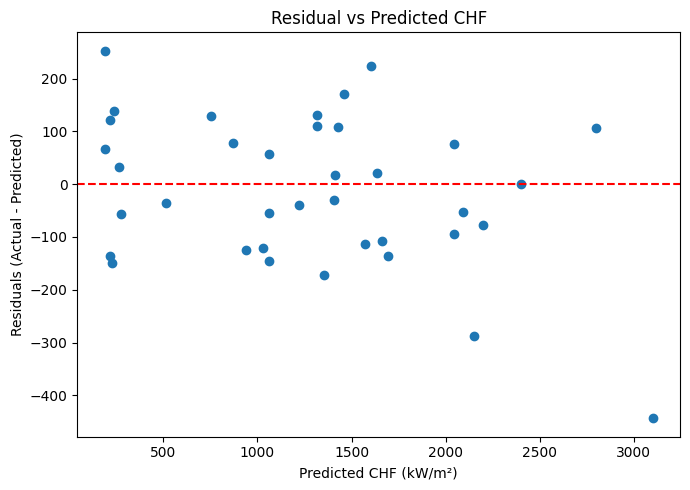

Saved: Residual_vs_Predicted_CHF.jpg


In [68]:
import matplotlib.pyplot as plt

# Residuals
resid = y_pred_final - y_test

plt.figure(figsize=(7,5))
plt.scatter(y_test, resid)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted CHF (kW/m²)")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residual vs Predicted CHF")
plt.tight_layout()

# ---- Save as high-quality JPEG ----
plt.savefig(
    "Residual_vs_Predicted_CHF.jpg",
    format="jpg",
    dpi=300,
    bbox_inches='tight'
)

plt.savefig(
    f"{save_dir}/Residual_vs_Predicted_CHF.jpg",
    format="jpg",
    dpi=300,
    bbox_inches='tight'
)

plt.show()

print("Saved: Residual_vs_Predicted_CHF.jpg")




=== XGBoost Feature Importance (Gain-based) ===
  Feature     Importance
0      kf  468994.593750
1    Tsat  358689.093750
2      ks   40633.832031
3       P   24114.744141
4      Ra   23768.480469


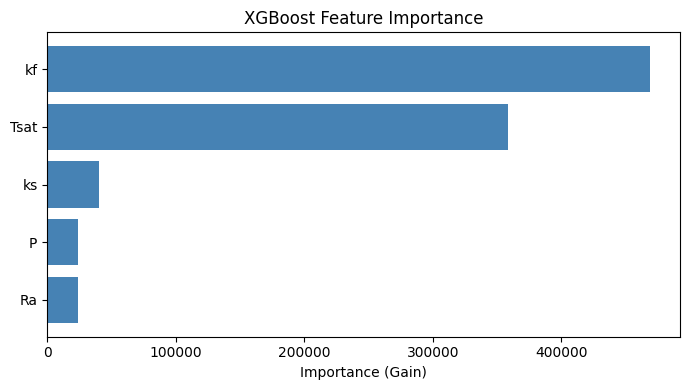

Saved JPEG: xgboost_feature_importance_gain.jpg


In [69]:
# Extract XGBoost booster (already trained with early stopping)
model = booster

# Get gain-based feature importance
importances = model.get_score(importance_type="gain")

feature_importance_df = pd.DataFrame({
    "Feature": list(importances.keys()),
    "Importance": list(importances.values())
}).sort_values(by="Importance", ascending=False).reset_index(drop=True)

print("\n=== XGBoost Feature Importance (Gain-based) ===")
print(feature_importance_df)

# -------- Plot --------
plt.figure(figsize=(7,4))
plt.barh(feature_importance_df["Feature"], feature_importance_df["Importance"], color='steelblue')
plt.gca().invert_yaxis()
plt.xlabel("Importance (Gain)")
plt.title("XGBoost Feature Importance")
plt.tight_layout()

# -------- Save as high-quality JPEG --------
filename = "xgboost_feature_importance_gain.jpg"

plt.savefig(filename, format="jpg", dpi=300, bbox_inches='tight')
plt.savefig(f"{save_dir}/filename", format="jpg", dpi=300, bbox_inches='tight')

plt.show()

print(f"Saved JPEG: {filename}")


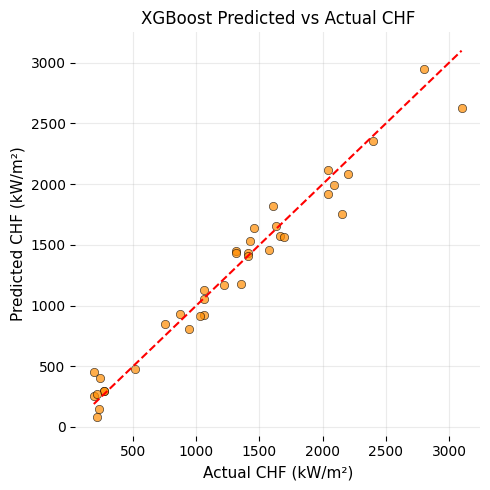

Saved: xgb_pred_vs_actual_plain.jpg


In [70]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(5,5))
sns.scatterplot(
    x=y_test,       # <-- FIXED
    y=y_pred,       # <-- predicted values
    color='darkorange',
    alpha=0.7,
    edgecolor='k',
    linewidth=0.5
)

# 1:1 line
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    'r--', lw=1.5
)

# Labels and title
plt.xlabel("Actual CHF (kW/m²)", fontsize=11)
plt.ylabel("Predicted CHF (kW/m²)", fontsize=11)
plt.title("XGBoost Predicted vs Actual CHF", fontsize=12)

# Remove axes boxes (top/right/bottom/left spines)
for spine in ["top", "right", "left", "bottom"]:
    plt.gca().spines[spine].set_visible(False)

# Optional: lighter grid for clean look
plt.grid(alpha=0.25)

plt.tight_layout()

# Save as high-quality JPEG
plt.savefig("xgb_pred_vs_actual_plain.jpg", format="jpg", dpi=300, bbox_inches="tight")
plt.savefig(f"{save_dir}/xgb_pred_vs_actual_plain.jpg", format="jpg", dpi=300, bbox_inches='tight')

plt.show()

print("Saved: xgb_pred_vs_actual_plain.jpg")


In [71]:
# === 5. Summary Table ===
summary_table = pd.DataFrame({
    "Metric": ["RMSE", "MAE", "R²"],
    "Value": [rmse, mae, r2]
})
print("\nPerformance Summary Table:")
display(summary_table)



Performance Summary Table:


,Metric,Value
0,RMSE,150.546599
1,MAE,115.894452
2,R²,0.960589


In [72]:
# 0) Ensure SHAP is available
try:
    import shap
except ImportError:
    raise SystemExit("Please install shap first: pip install shap")

# 1) Recompute predictions & metrics (for completeness)
y_pred = best_pipe.predict(pd.DataFrame(X_test, columns=feature_columns))
mse  = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)
print("MODEL PERFORMANCE SUMMARY (for SHAP report)")
print(f"  RMSE : {rmse:.3f}")
print(f"  MAE  : {mae:.3f}")
print(f"  R²   : {r2:.4f}")
print("-"*60)


MODEL PERFORMANCE SUMMARY (for SHAP report)
  RMSE : 138.701
  MAE  : 109.785
  R²   : 0.9665
------------------------------------------------------------


In [73]:
# 2) Prepare the imputed test matrix (so SHAP sees what the model saw)
# best_pipe is the scikit-learn pipeline with the XGBoost model

# Manually apply imputation using SimpleImputer fitted on training data
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")
imputer.fit(X_train[feature_columns]) # Fit imputer on training data
X_test_imp = pd.DataFrame(imputer.transform(X_test[feature_columns]), columns=feature_columns)


# (Optional) For speed on very large sets, sample the SHAP background:
bg_idx = np.random.RandomState(42).choice(len(X_test_imp),
                                          size=min(200, len(X_test_imp)),
                                          replace=False)
X_bg = X_test_imp.iloc[bg_idx]


In [74]:
# 3) Build a SHAP explainer (TreeExplainer for XGBoost)
# Use version-compatible path: prefer TreeExplainer for XGBoost
# Extract the fitted XGBoost model from the pipeline
xgb_model = best_pipe.named_steps['model']

try:
    explainer = shap.TreeExplainer(xgb_model, feature_perturbation="tree_path_dependent")
except Exception:
    # fall back to generic Explainer if needed
    explainer = shap.Explainer(xgb_model, X_bg)


In [75]:
# 4) Compute SHAP values
# For newer SHAP, explainer(X) returns a Explanation; older returns array/list
shap_vals = explainer(X_test_imp)

# Normalize to array + ensure 2D for plotting
if hasattr(shap_vals, "values"):
    sv = shap_vals.values
else:
    sv = shap_vals
if isinstance(sv, list):  # older SHAP for multiclass; for regression usually single array
    sv = sv[0]
# sv shape: (n_samples, n_features)


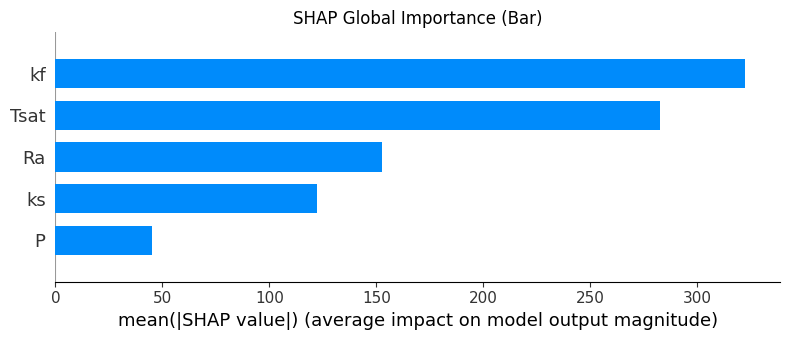

Saved: shap_global_importance_bar.jpg


In [76]:
import matplotlib.pyplot as plt
import shap

# 5) Global importance — bar chart
plt.figure(figsize=(7,4))
shap.summary_plot(sv, X_test_imp, plot_type="bar", show=False)
plt.title("SHAP Global Importance (Bar)")
plt.tight_layout()

# Save as high-quality JPEG
plt.savefig("shap_global_importance_bar.jpg", format="jpg", dpi=300, bbox_inches="tight")
plt.savefig(f"{save_dir}/shap_global_importance_bar.jpg", format="jpg", dpi=300, bbox_inches='tight')

plt.show()
print("Saved: shap_global_importance_bar.jpg")


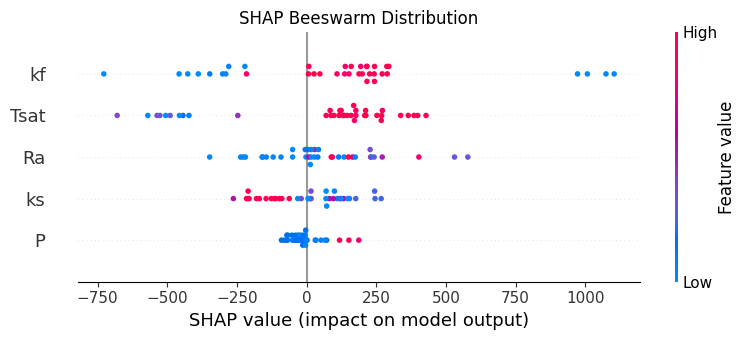

Saved: shap_beeswarm.jpg


In [77]:
# 6) Global distribution — beeswarm
plt.figure(figsize=(7,4))
shap.summary_plot(sv, X_test_imp, show=False)
plt.title("SHAP Beeswarm Distribution")
plt.tight_layout()

# Save as high-quality JPEG
plt.savefig("shap_beeswarm.jpg", format="jpg", dpi=300, bbox_inches="tight")
plt.savefig(f"{save_dir}/shap_beeswarm.jpg", format="jpg", dpi=300, bbox_inches='tight')

plt.show()
print("Saved: shap_beeswarm.jpg")


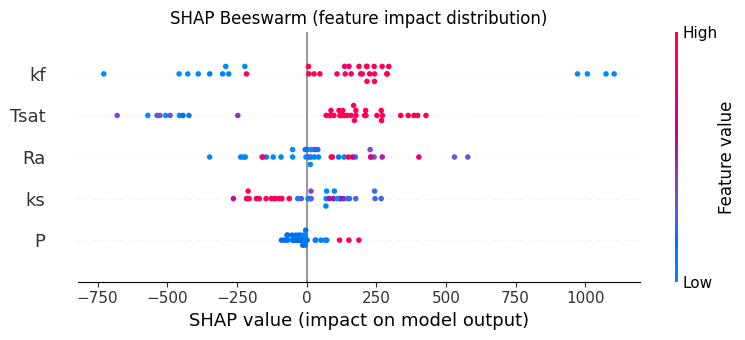

Saved: shap_beeswarm.jpg


In [78]:
# 6) Global distribution — beeswarm
plt.figure(figsize=(7, 4))
shap.summary_plot(sv, X_test_imp, show=False)
plt.title("SHAP Beeswarm (feature impact distribution)")
plt.tight_layout()

# ---- Save as high-quality JPEG ----
plt.savefig("shap_beeswarm.jpg", format="jpg", dpi=300, bbox_inches='tight')
plt.savefig(f"{save_dir}/shap_beeswarm.jpg", format="jpg", dpi=300, bbox_inches='tight')

plt.show()

print("Saved: shap_beeswarm.jpg")


Top SHAP features: ['kf', 'Tsat', 'Ra']


<Figure size 600x400 with 0 Axes>

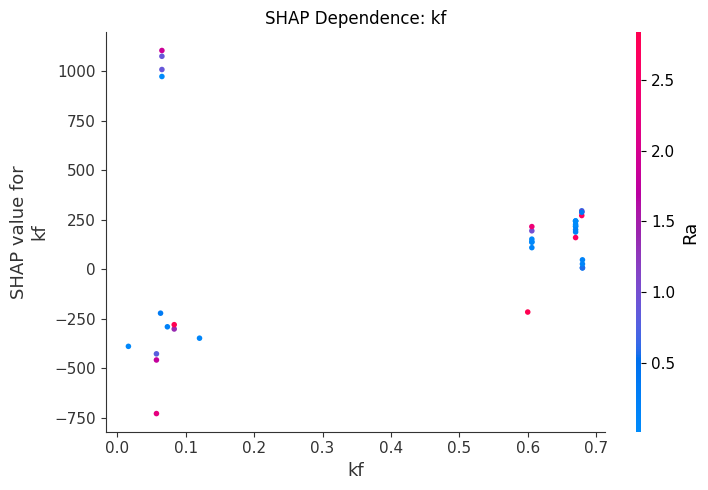

Saved: SHAP_Dependence.jpg


<Figure size 600x400 with 0 Axes>

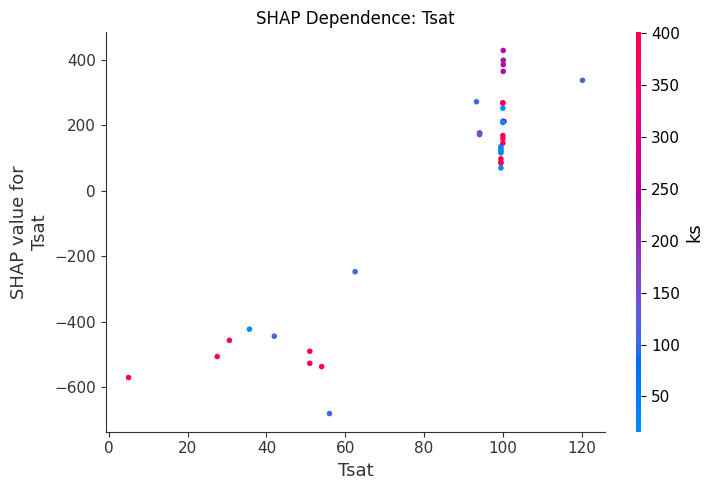

Saved: SHAP_Dependence.jpg


<Figure size 600x400 with 0 Axes>

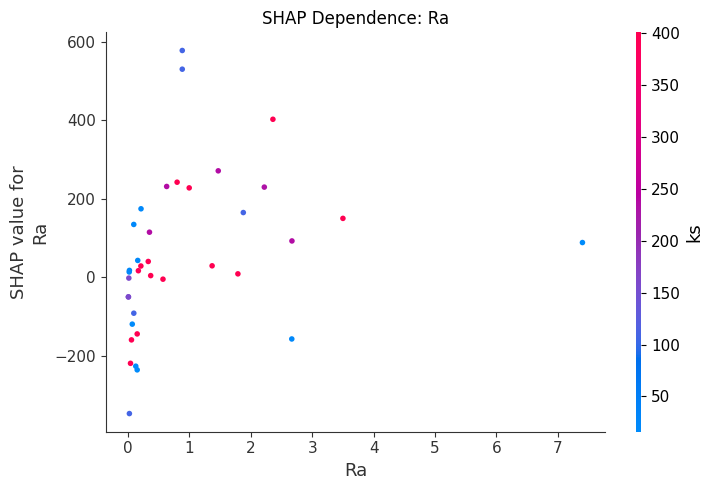

Saved: SHAP_Dependence.jpg


In [79]:
# ------------------------------------------------------------
# 7) SHAP Dependence Plots for Top 3 Features — 300 DPI JPEG
# ------------------------------------------------------------

mean_abs = np.abs(sv).mean(axis=0)
top_idx = np.argsort(-mean_abs)[:3]
top_feats = [feature_columns[i] for i in top_idx]

print("Top SHAP features:", top_feats)

for f in top_feats:
    plt.figure(figsize=(6, 4))

    # SHAP dependence plot (auto-selects interaction feature)
    shap.dependence_plot(f, sv, X_test_imp, show=False)

    plt.title(f"SHAP Dependence: {f}")
    plt.tight_layout()

    # ---- Safe filename ----
    filname = f"SHAP_Dependence_{f}.jpg".replace("/", "_")

    # ---- Save as high-quality JPEG ----
    plt.savefig(filname, format="jpg", dpi=300, bbox_inches='tight')
    plt.savefig(f"{save_dir}/filname.jpg", format="jpg", dpi=300, bbox_inches='tight')

    plt.show()

    print(f"Saved: SHAP_Dependence.jpg")


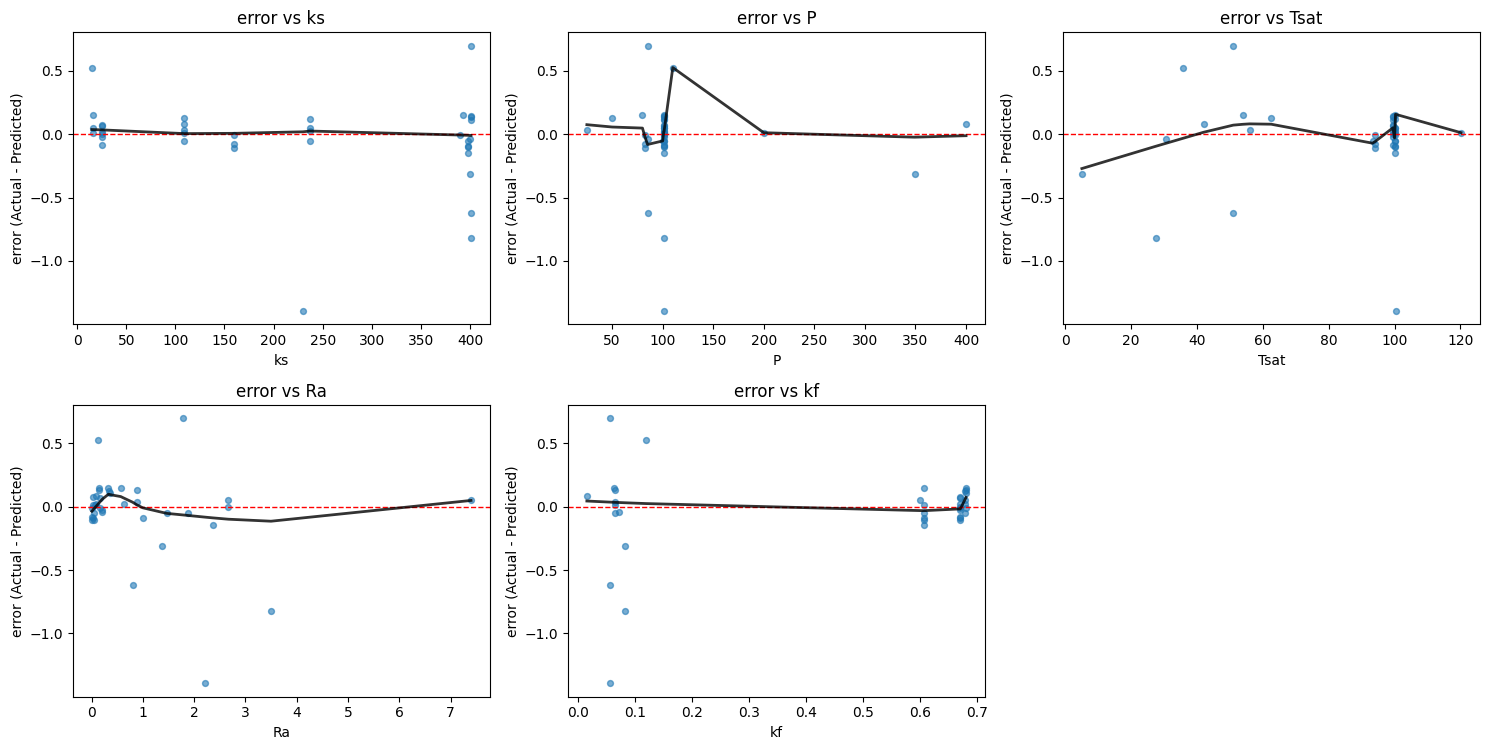

Saved: Residuals_by_Feature_grid.jpg


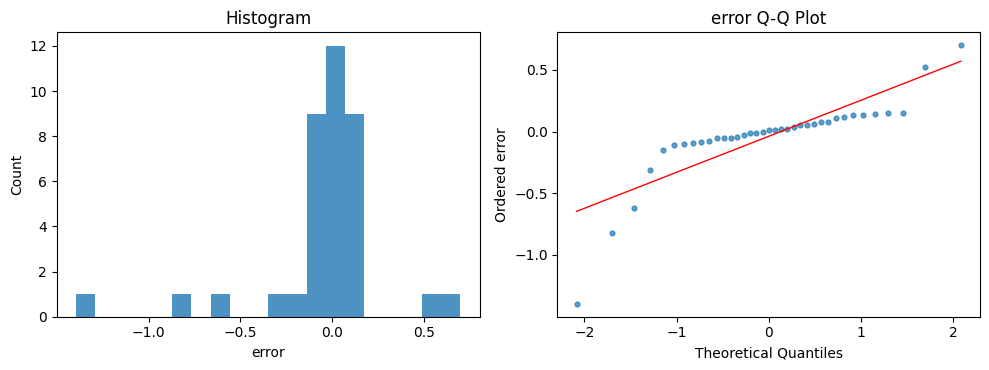

Saved: Residual_Histogram_and_QQ.jpg


In [80]:
# RESIDUALS-BY-FEATURE GRID
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# assumes: best_pipe, X_test, y_test, feature_columns, save_dir exist

# If y_pred isn't computed yet, do it now
try:
    y_pred
except NameError:
    y_pred = best_pipe.predict(pd.DataFrame(X_test, columns=feature_columns))

# Define relative error as (Actual - Predicted)/Actual
error = (y_test - y_pred) / y_test

# Build plotting DataFrame
plot_df = pd.DataFrame(X_test, columns=feature_columns).copy()
plot_df["error"] = error.values
plot_df["Predicted"] = y_pred
plot_df["Actual"] = y_test.values

# Try to import LOWESS for a smooth trend line
try:
    from statsmodels.nonparametric.smoothers_lowess import lowess
    have_lowess = True
except Exception:
    have_lowess = False

# Layout for residuals-by-feature grid
feats = feature_columns
n = len(feats)
cols = 3
rows = int(np.ceil(n / cols))

fig, axes = plt.subplots(rows, cols,
                         figsize=(5*cols, 3.8*rows),
                         squeeze=False)
axes = axes.ravel()

for i, f in enumerate(feats):
    ax = axes[i]
    x = plot_df[f].values
    y = plot_df["error"].values
    ax.scatter(x, y, alpha=0.6, s=18)
    ax.axhline(0.0, color="red", linestyle="--", linewidth=1)
    ax.set_title(f"error vs {f}")
    ax.set_xlabel(f)
    ax.set_ylabel("error (Actual - Predicted)")

    # Overlay LOWESS if available and enough unique x
    if have_lowess and np.unique(x).size > 10:
        lo = lowess(y, x, frac=0.6, return_sorted=True)
        ax.plot(lo[:, 0], lo[:, 1], color="black", linewidth=2, alpha=0.8)

# Turn off any empty subplots
for j in range(i + 1, rows*cols):
    fig.delaxes(axes[j])

plt.tight_layout()

# ---- Save as high-quality JPEG ----
fname_grid = "Residuals_by_Feature_grid.jpg"
fig.savefig(fname_grid, format="jpg", dpi=300, bbox_inches='tight')
plt.savefig(f"{save_dir}/fname_grid.jpg", format="jpg", dpi=300, bbox_inches='tight')

plt.show()
print(f"Saved: {fname_grid}")

# -------------------------------------------------
# Residual distribution & Q-Q plot (sanity check)
# -------------------------------------------------
fig2, ax = plt.subplots(1, 2, figsize=(10, 3.8))

# Histogram of relative error
ax[0].hist(error, bins=20, alpha=0.8)
ax[0].set_title("Histogram")
ax[0].set_xlabel("error")
ax[0].set_ylabel("Count")

# Q-Q plot
try:
    import scipy.stats as st
    (osm, osr), (slope, intercept, r) = st.probplot(error, dist="norm", plot=None)
    ax[1].scatter(osm, osr, s=12, alpha=0.7)
    line = slope * osm + intercept
    ax[1].plot(osm, line, color="red", linewidth=1)
    ax[1].set_title("error Q-Q Plot")
    ax[1].set_xlabel("Theoretical Quantiles")
    ax[1].set_ylabel("Ordered error")
except Exception:
    ax[1].text(0.5, 0.5, "scipy not available for Q-Q plot",
               ha="center", va="center")
    ax[1].set_axis_off()

plt.tight_layout()

# ---- Save as high-quality JPEG ----
fname_qq = "Residual_Histogram_and_QQ.jpg"
fig2.savefig(fname_qq, format="jpg", dpi=300, bbox_inches='tight')
plt.savefig(f"{save_dir}/fname_qq.jpg", format="jpg", dpi=300, bbox_inches='tight')

plt.show()
print(f"Saved: {fname_qq}")


In [81]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error

# === 1. Settings ===
FLUID_COL = "working_fluid"   # <-- CHANGE THIS if your column has a different name

# === 2. Build a test-set frame with truth, prediction, and fluid label ===
# X_test comes from your earlier train_test_split(X, y, ...)
# y_test, y_pred_final are already defined

test_idx = X_test.index  # indices of test rows in the original df

test_df = pd.DataFrame({
    "y_true": y_test.values,
    "y_pred": y_pred_final,
    FLUID_COL: df.loc[test_idx, FLUID_COL].values
})

# Optional: check a few rows
print(test_df.head())

# === 3. Helper for RMSE ===
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# === 4. Stratified error by fluid type ===
rows = []
for fluid, group in test_df.groupby(FLUID_COL):
    y_t = group["y_true"].values
    y_p = group["y_pred"].values
    n   = len(group)

    rmse_val = rmse(y_t, y_p)
    mae_val  = mean_absolute_error(y_t, y_p)

    rows.append({
        "FluidType": fluid,
        "RMSE": rmse_val,
        "MAE": mae_val,
        "n_test": n,
    })

strat_fluid_df = pd.DataFrame(rows)

# Round for reporting
strat_fluid_df["RMSE"] = strat_fluid_df["RMSE"].round(2)
strat_fluid_df["MAE"]  = strat_fluid_df["MAE"].round(2)

# Sort by sample count (optional, but usually nice)
strat_fluid_df = strat_fluid_df.sort_values("n_test", ascending=False)

print("\n=== Stratified Test Error by Fluid Type (XGBoost) ===")
print(strat_fluid_df.to_string(index=False))


        y_true       y_pred working_fluid
0  2042.250000  1947.335205         Water
1   227.941177    79.341919       Pentane
2  1063.000000  1120.883789         Water
3   751.518388   881.307251         Water
4  1412.000000  1428.473389         Water

=== Stratified Test Error by Fluid Type (XGBoost) ===
       FluidType   RMSE    MAE  n_test
           Water 125.35 108.56      24
        HFE-7100 208.46 137.17       5
         PF-5060 128.45 128.24       2
          Butane  36.37  36.37       1
HFE-7000 (Novec)  33.48  33.48       1
           FC-77 252.80 252.80       1
         Pentane 148.60 148.60       1
           R-123 139.46 139.46       1
          R-134a  65.96  65.96       1


In [82]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error

# === 1. Column name for pressure in your df ===
P_COL = "P"   # change if your pressure column has a different name

# === 2. Build test-set frame with truth, prediction, and pressure ===
test_idx = X_test.index

test_p_df = pd.DataFrame({
    "y_true": y_test.values,
    "y_pred": y_pred_final,
    P_COL: df.loc[test_idx, P_COL].values  # pressure in kPa
})

# Optional: sanity check
print(test_p_df.head())

# === 3. Define pressure regimes (you can tweak the bin edges if needed) ===
# Example: Low (≤100 kPa), Medium (100–200 kPa), High (>200 kPa)
pressure_bins = [0, 100, 200, np.inf]
pressure_labels = [
    "Low (≤100 kPa)",
    "Medium (100–200 kPa)",
    "High (>200 kPa)"
]

test_p_df["P_regime"] = pd.cut(
    test_p_df[P_COL],
    bins=pressure_bins,
    labels=pressure_labels,
    include_lowest=True
)

# === 4. Helper for RMSE ===
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# === 5. Stratified error by pressure regime ===
rows_p = []
for regime, group in test_p_df.groupby("P_regime"):
    y_t = group["y_true"].values
    y_p = group["y_pred"].values
    n   = len(group)

    rmse_val = rmse(y_t, y_p)
    mae_val  = mean_absolute_error(y_t, y_p)

    rows_p.append({
        "PressureRegime": regime,
        "RMSE": rmse_val,
        "MAE": mae_val,
        "n_test": n,
    })

strat_P_df = pd.DataFrame(rows_p)

# Round for reporting
strat_P_df["RMSE"] = strat_P_df["RMSE"].round(2)
strat_P_df["MAE"]  = strat_P_df["MAE"].round(2)

# Sort by regime order (or by pressure center if you prefer)
# Here we keep the original category order
strat_P_df["PressureRegime"] = strat_P_df["PressureRegime"].astype(str)

print("\n=== Stratified Test Error by Pressure Regime (XGBoost) ===")
print(strat_P_df.to_string(index=False))


        y_true       y_pred       P
0  2042.250000  1947.335205  101.30
1   227.941177    79.341919  110.00
2  1063.000000  1120.883789  101.30
3   751.518388   881.307251  101.00
4  1412.000000  1428.473389   82.13

=== Stratified Test Error by Pressure Regime (XGBoost) ===
      PressureRegime   RMSE    MAE  n_test
      Low (≤100 kPa) 167.65 123.26      10
Medium (100–200 kPa) 134.59 115.58      25
     High (>200 kPa)  53.26  51.17       2


/tmp/ipython-input-3495439563.py:42: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for regime, group in test_p_df.groupby("P_regime"):


In [83]:
import numpy as np
import pandas as pd

# =========================================
# 1. Build residual dataframe
# =========================================

test_idx = X_test.index

residual_df = pd.DataFrame({
    "y_true": y_test.values,                # true CHF (from split)
    "y_pred": y_pred_final,                 # model predictions
    "residual": y_test.values - y_pred_final,
    "working_fluid": df.loc[test_idx, "working_fluid"].values,
    "pressure_kPa": df.loc[test_idx, "P"].values,       # operating pressure
    "study_id": df.loc[test_idx, "study_id"].values,    # <-- FIXED
})

# =========================================
# 2. Compute Z-scores of residuals
# =========================================

mu = residual_df["residual"].mean()
sigma = residual_df["residual"].std(ddof=0)

residual_df["z_score"] = (residual_df["residual"] - mu) / sigma

# =========================================
# 3. Flag outliers using |Z| > 3
# =========================================

residual_df["is_outlier"] = residual_df["z_score"].abs() > 3

outliers_df = residual_df[residual_df["is_outlier"]].copy()
outliers_df = outliers_df.sort_values(by="z_score", key=np.abs, ascending=False)

# =========================================
# 4. Print summary
# =========================================

n_outliers = outliers_df.shape[0]
n_total = residual_df.shape[0]
percent = 100 * n_outliers / n_total

print("\n=== Outlier Detection (Z-score, |Z| > 3) ===")
print(f"Total test samples: {n_total}")
print(f"Outliers detected: {n_outliers} ({percent:.2f}%)\n")

if n_outliers > 0:
    print("=== Outlier Details ===")
    print(outliers_df[[
        "y_true", "y_pred", "residual", "z_score",
        "working_fluid", "pressure_kPa", "study_id"      # <-- FIXED
    ]].to_string(index=False))
else:
    print("No outliers detected under |Z| > 3 criterion.")



=== Outlier Detection (Z-score, |Z| > 3) ===
Total test samples: 37
Outliers detected: 1 (2.70%)

=== Outlier Details ===
 y_true      y_pred   residual  z_score working_fluid  pressure_kPa      study_id
 3100.0 2656.526367 443.473633 3.050444      HFE-7100          50.0 Alvarino_2019
